In [1]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')

import experiment as exp
import model as m
import plot
import predict
import runner2 as r

import numpy as np
import matplotlib.pyplot as plt

import os
import torch

import umap
import matplotlib
from sklearn.preprocessing import StandardScaler

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

_ = plt.rcParams['axes.grid'] = False # turn off grid

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0')

Invoking __init__.py for NDNT.utils


In [2]:
e = exp.load('iter_exps12_3iters', experiment_location='experiments', datadir='Mdata')
np.mean(e.trials[0].LLs)

0.09551196

In [3]:
dataset = e.trials[0].dataset
expt_boundaries = np.concatenate([[0], np.cumsum(dataset.num_units)])
expt_boundaries

lazy loading dataset
Loading expt04
  Time embedding...
  Done.
Loading expt06
  Time embedding...
  Done.
Loading expt09
  Time embedding...
  Done.
Loading expt11
  Time embedding...
  Done.


array([  0,  35,  63,  86, 111])

In [4]:
dataset.filenames

['expt04', 'expt06', 'expt09', 'expt11']

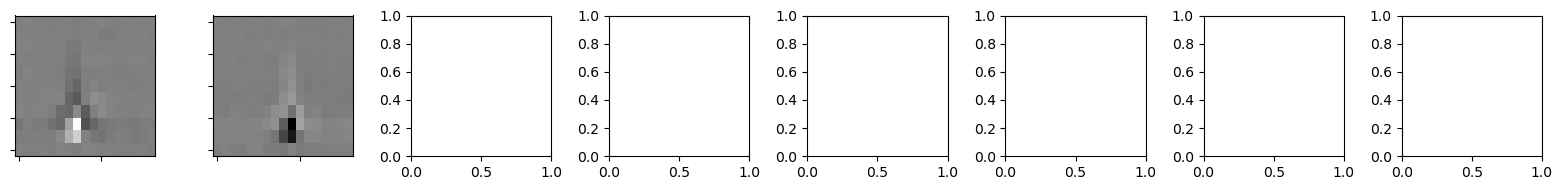

In [5]:
e.trials[0].model.NDN.plot_filters()

# readout weights

(66, 111)


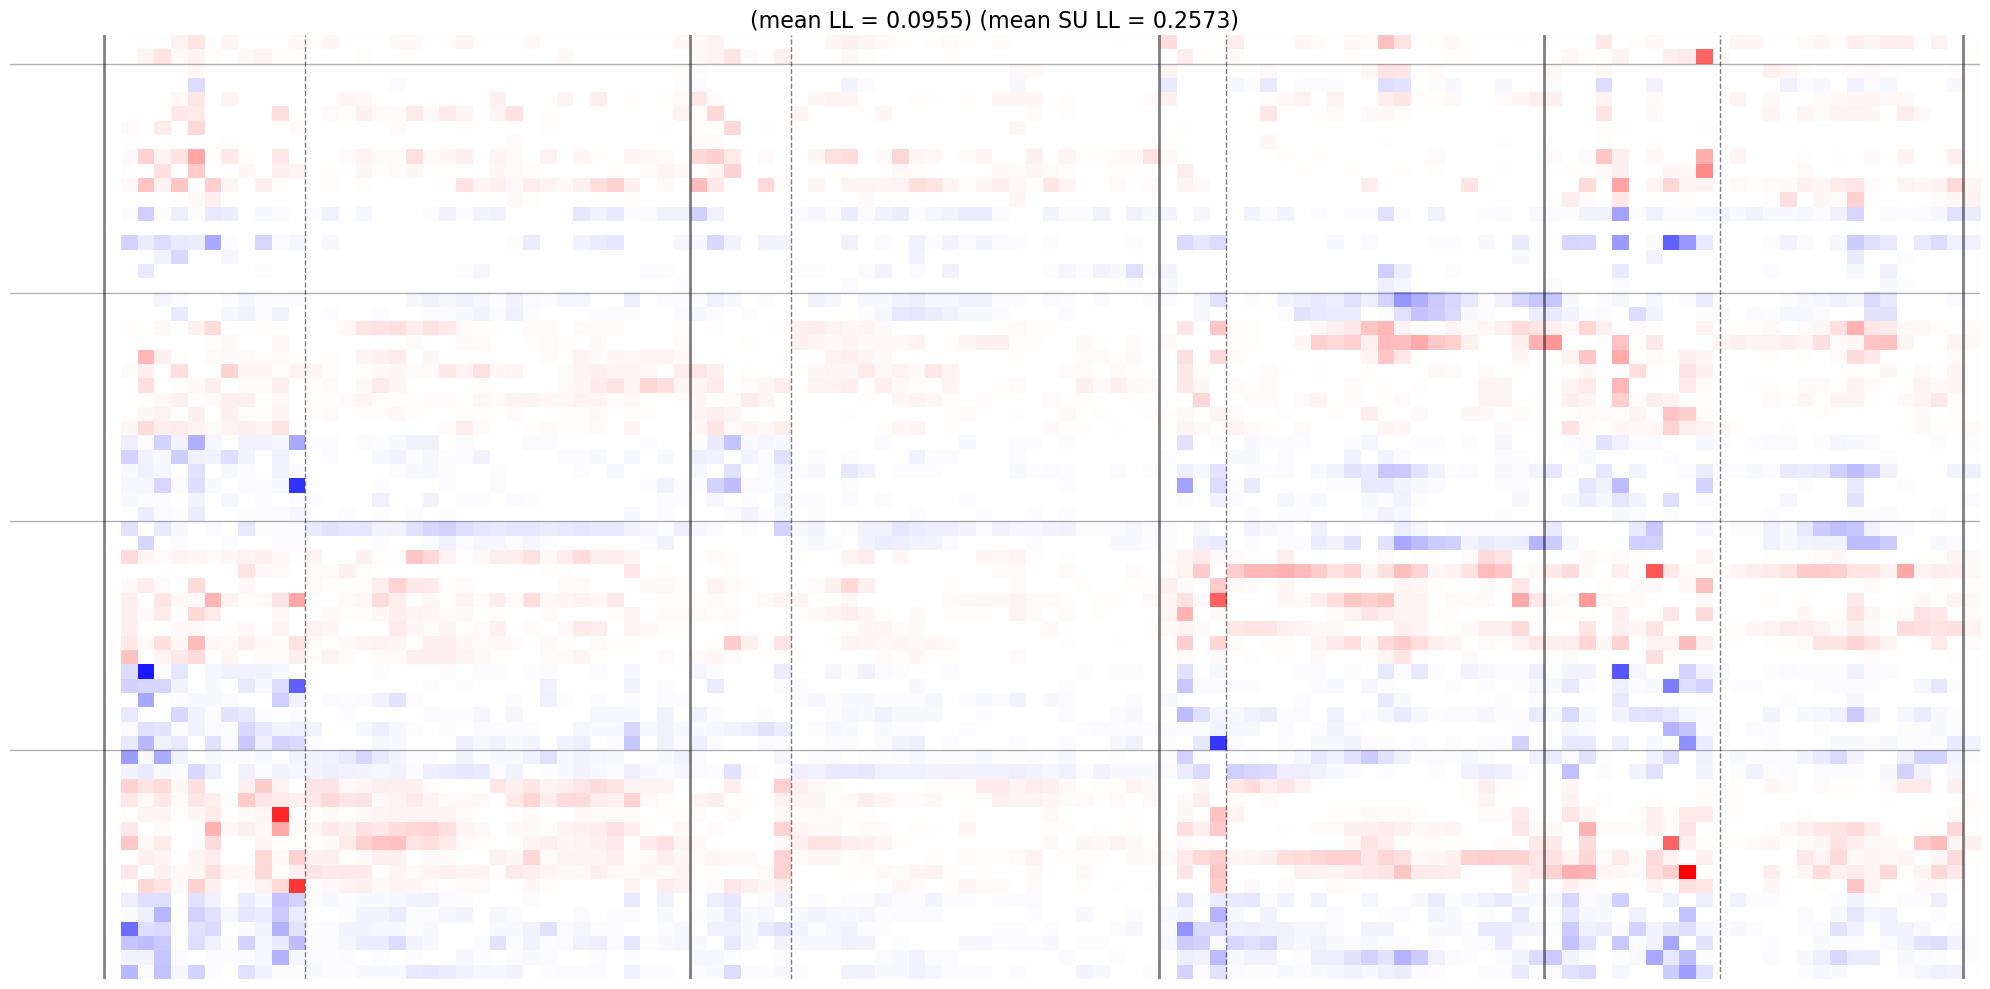

In [6]:
readout_weights = np.sum(e.trials[0].model.networks[-1].layers[-1].weights[:,:,:], axis=1)
print(readout_weights.shape)
# make inhibitory weights negative (every 12 weights need to be flipped)
readout_weights[3,:] = -readout_weights[3,:]
for i in range(12,readout_weights.shape[0],16):
    readout_weights[i:i+8,:] = -readout_weights[i:i+8,:]

# get the mean LLs for just the SUs in k
mean_SU_LLs = np.mean(e.trials[0].LLs[dataset.SUs])

# get the mean LLs for k
mean_LLs = np.mean(e.trials[0].LLs)

fig = plt.figure(figsize=(20,10))
plot.imagesc(readout_weights, cmap='bwr', colrow=False, origin='upper')
plt.title('(mean LL = %.4f)' % mean_LLs + ' (mean SU LL = %.4f)' % mean_SU_LLs, fontsize=16)
plt.axis('off')

# put a vertical line between each experiment
for expt_boundary in expt_boundaries:
    plt.axvline(expt_boundary-1-0.5, color='k', linewidth=2, alpha=0.5)

# put a vertical line between the SUs and the MUs
# get the indices of the SUs where the experiment boundaries are
SU_boundaries = np.where(np.diff(dataset.SUs) > 1)[0]

for SU_boundary in SU_boundaries:
    plt.axvline(dataset.SUs[SU_boundary]+1-0.5, color='k', linewidth=1, alpha=0.5, linestyle='--')
# plot the last SU boundary
plt.axvline(dataset.SUs[-1]+1, color='k', linewidth=1, alpha=0.5, linestyle='--')

layer_boundaries = [0, 2, 18, 34, 50, 66]

# put a horizontal line between each layer
for layer_boundary in layer_boundaries[1:-1]:
    plt.axhline(layer_boundary-0.5, color='k', linewidth=1, alpha=0.3)

plt.tight_layout()
plt.show()

# projection weights

Projection weights shape (2, 15, 16)


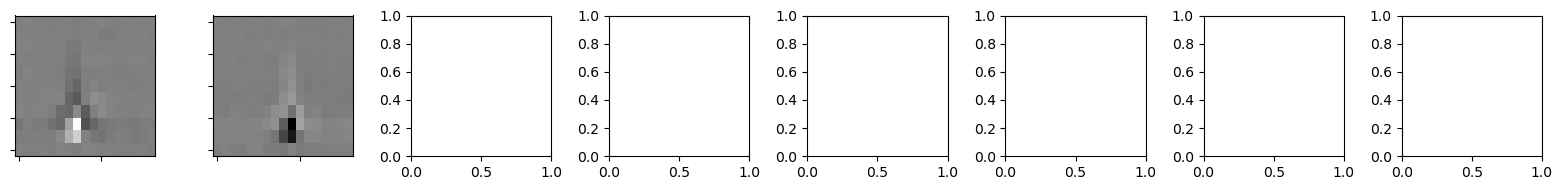

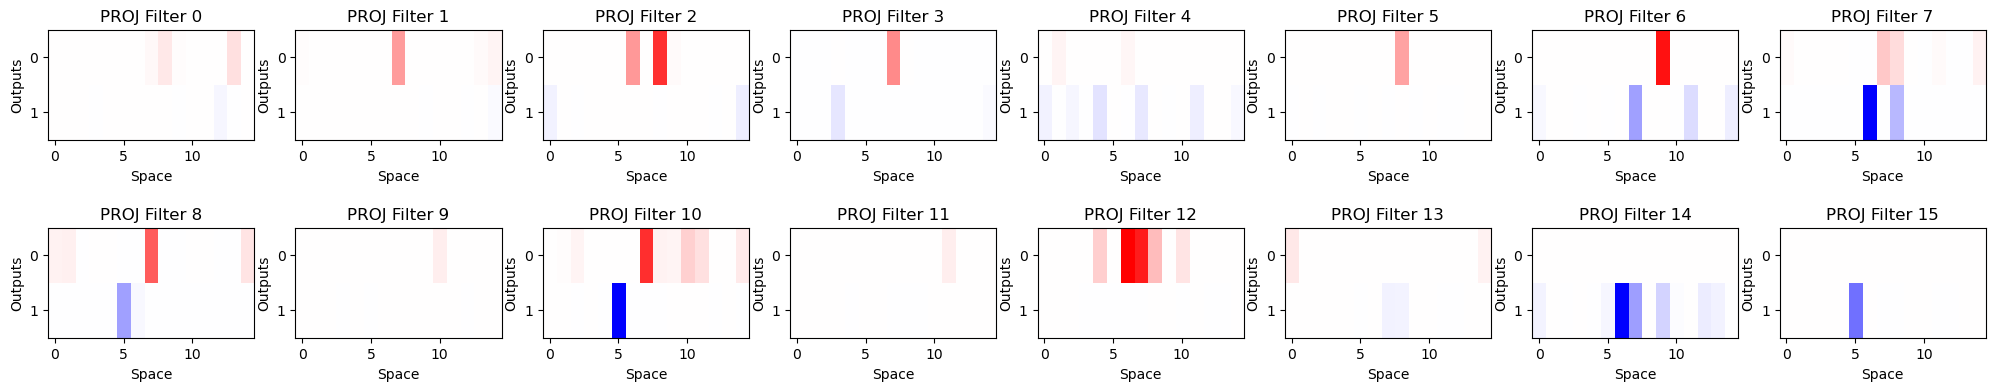

In [7]:
proj_weights = e.trials[0].model.networks[0].layers[1].weights
proj_weights[1,:,:] = -proj_weights[1,:,:]
proj_max = np.max(proj_weights)
proj_min = -proj_max

print('Projection weights shape', proj_weights.shape)

e.trials[0].model.NDN.plot_filters()

# make a 2x2 grid
fig = plt.figure(figsize=(25,4))
# put space between the plots
fig.subplots_adjust(wspace=0.2, hspace=0.8)
rows,cols = 2,8
gridspec = fig.add_gridspec(rows,cols)
for i in range(proj_weights.shape[2]):
    row,col = np.unravel_index(i, (rows,cols))
    ax = fig.add_subplot(gridspec[row,col])
    ax.imshow(proj_weights[:,:,i], cmap='bwr', aspect='auto', vmin=proj_min, vmax=proj_max)
    ax.set_title('PROJ Filter '+str(i))
    ax.set_xlabel('Space')
    ax.set_ylabel('Outputs')
plt.show()

# STAs

In [8]:
preds = predict.calc_preds(dataset, e.trials[0].model)

  7%|██████████▎                                                                                                                                     | 1/14 [00:20<04:31, 20.91s/it]

KeyboardInterrupt



In [ ]:
stas, pred = predict.calc_STAs(dataset, preds)

In [ ]:
plot.plot_STAs(stas, pred, dataset, e.trials[0])

In [ ]:
dirsel_neurons = [0, 2, 63, 87] + [1, 3, 36, 89]
print(dirsel_neurons)
# get the top spikes for the direction selective neurons
top_spikes = np.argsort(dataset.robs[:,dirsel_neurons], axis=0)[-10:,:]

In [ ]:
fig = plt.figure(figsize=(25,4))
for ni in range(len(dirsel_neurons)):
    plt.subplot(1,len(dirsel_neurons),ni+1)
    plt.hist(dataset.robs[top_spikes[:,ni], dirsel_neurons[ni]], bins=5)
    plt.title('Neuron %d' % dirsel_neurons[ni])
plt.show()
#torch.min(dataset.robs[top_spikes[:,0], dirsel_neurons[0]])

# jacobian

In [ ]:
# compare the average Jacobians for the direction selective neurons to the average Jacobians for the non-direction selective neurons

In [136]:
results = []
for ni in range(len(dirsel_neurons)):
    results.append(predict.predict(e.trials[0].model, dataset=dataset[top_spikes[:,ni]], calc_jacobian=True, verbose=False))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.54it/s]


Neuron readout weights shape (66, 36)
Num layers 3
--> 0 2
Network 0 Layer 0 Jacobian shape (10, 4, 2, 36, 504) Neuron weights shape (66, 36)
Layer readout weights shape (2, 36)
Layer Jacobians shape (4, 2, 36, 504)
--> 2 18
Network 0 Layer 1 Jacobian shape (10, 4, 16, 36, 504) Neuron weights shape (66, 36)
Layer readout weights shape (16, 36)
Layer Jacobians shape (4, 16, 36, 504)
--> 18 34
Network 0 Layer 2 Jacobian shape (10, 3, 16, 36, 504) Neuron weights shape (66, 36)
Layer readout weights shape (16, 36)
Layer Jacobians shape (3, 16, 36, 504)
Layer readout weights shape (16, 36)
Layer Jacobians shape (3, 16, 36, 504)
Layer readout weights shape (16, 36)
Layer Jacobians shape (3, 16, 36, 504)
Neuron readout weights shape (66, 36)
Num layers 3
--> 0 2
Network 0 Layer 0 Jacobian shape (10, 4, 2, 36, 504) Neuron weights shape (66, 36)
Layer readout weights shape (2, 36)
Layer Jacobians shape (4, 2, 36, 504)
--> 2 18
Network 0 Layer 1 Jacobian shape (10, 4, 16, 36, 504) Neuron weights

/tmp/ipykernel_101225/2911358912.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(subunits*2,1))


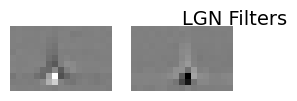

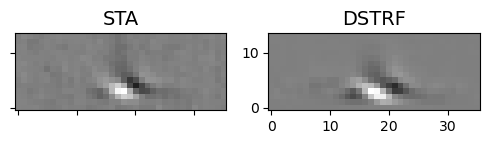

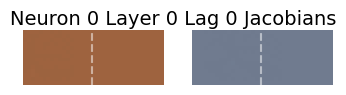

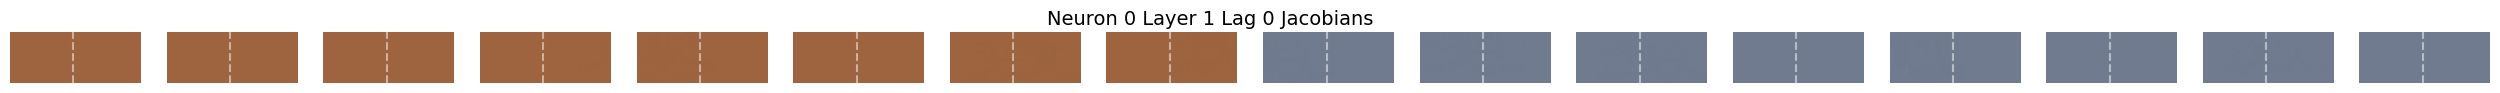

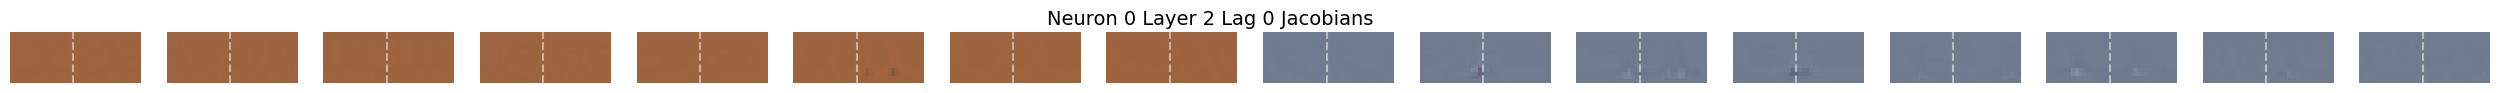

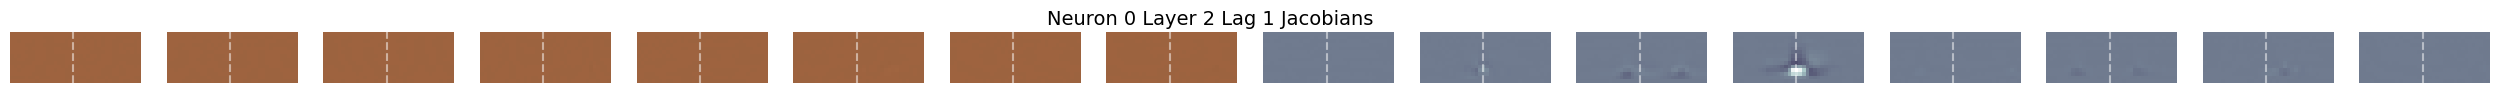

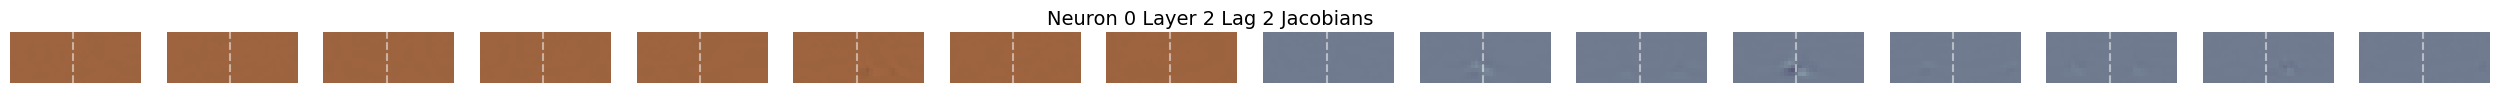

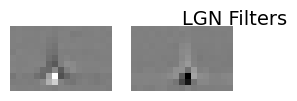

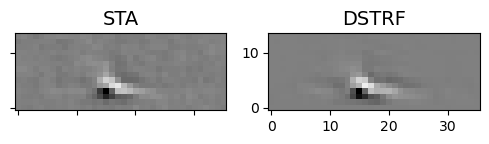

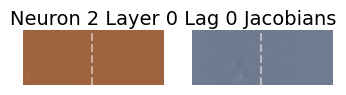

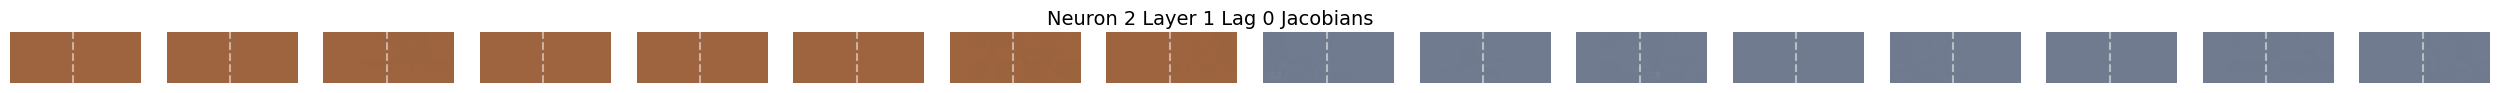

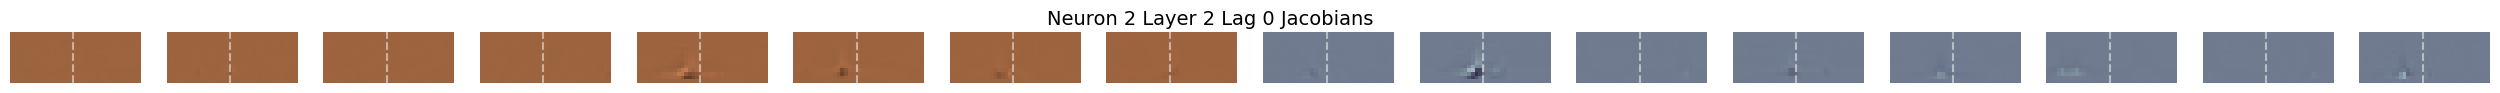

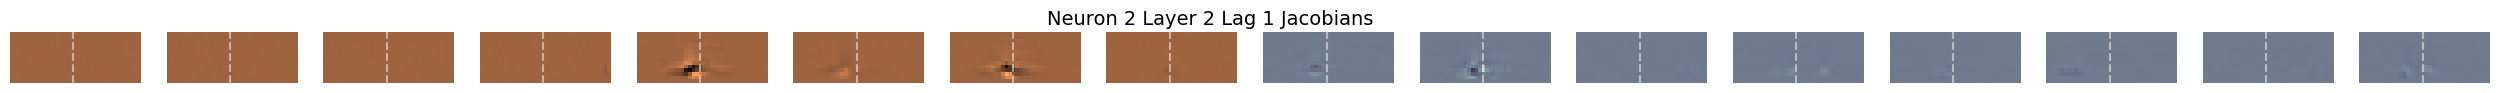

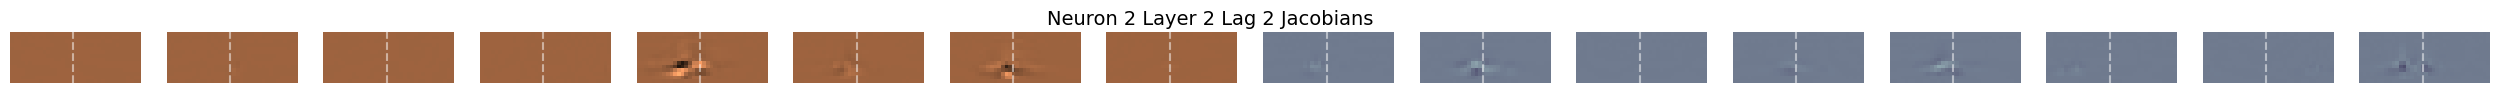

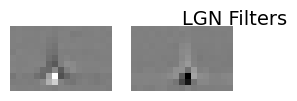

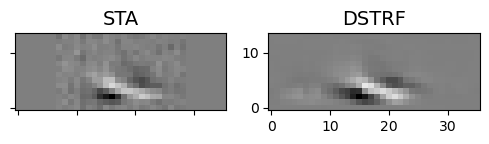

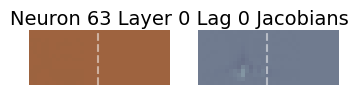

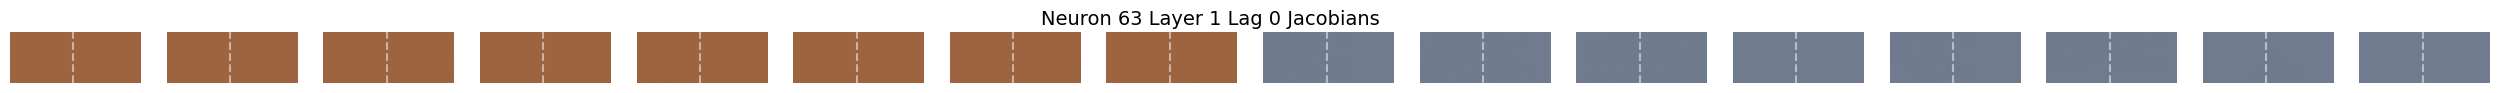

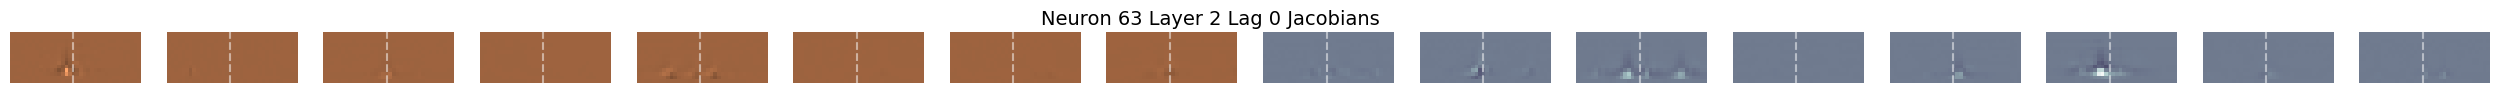

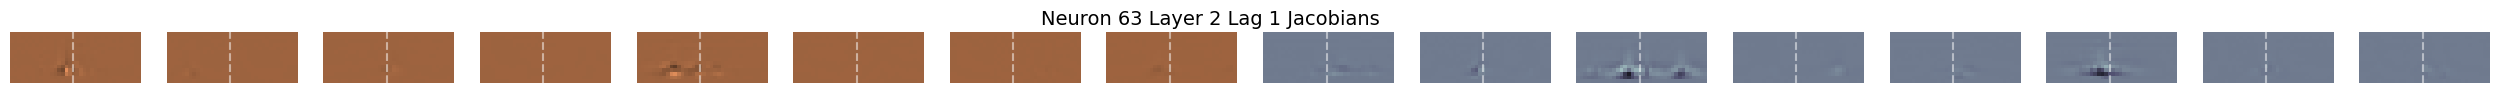

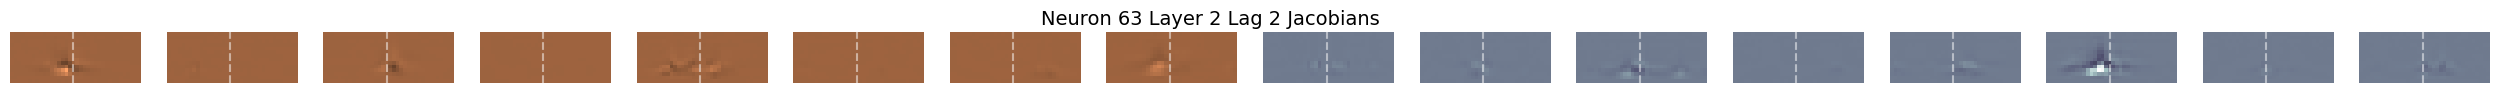

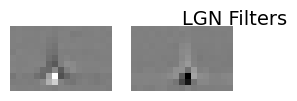

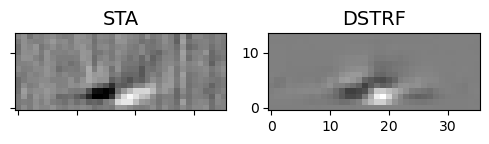

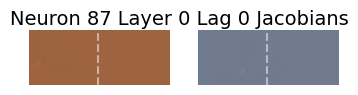

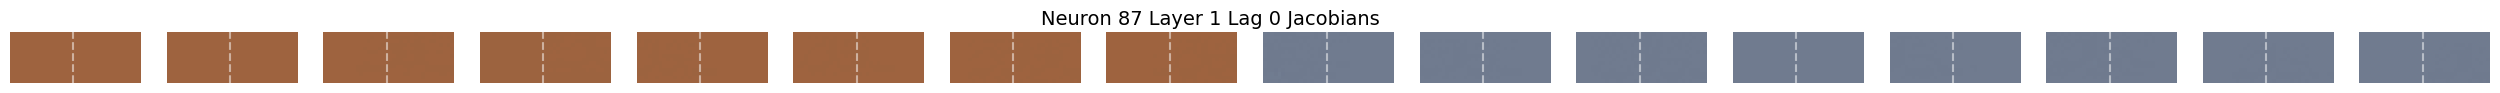

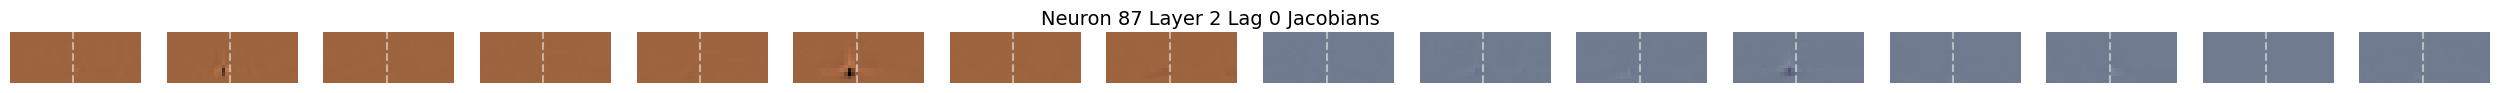

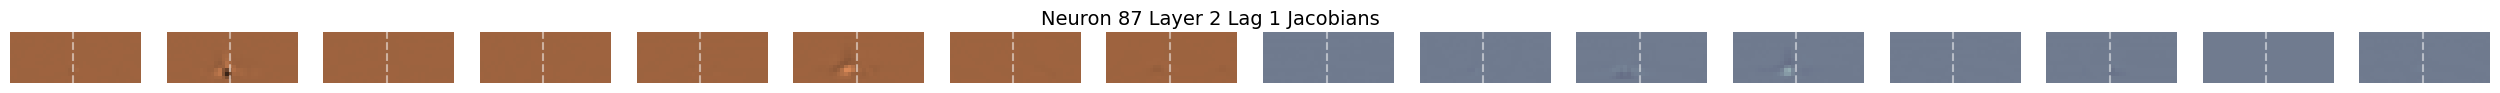

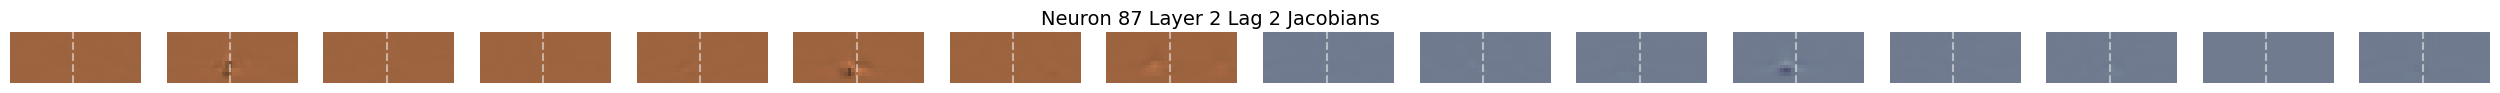

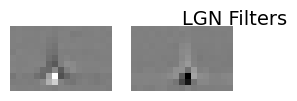

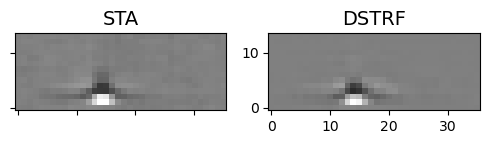

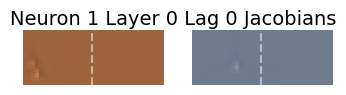

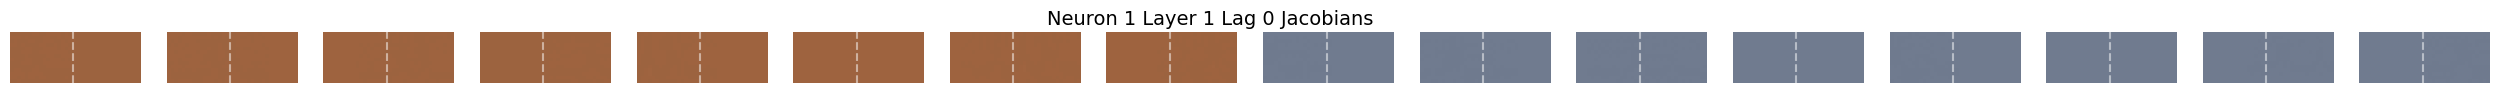

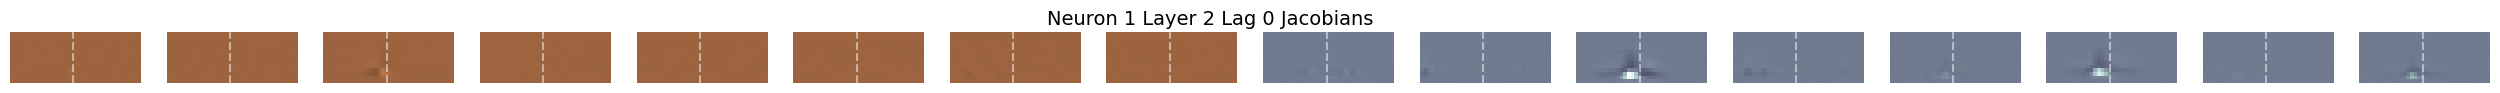

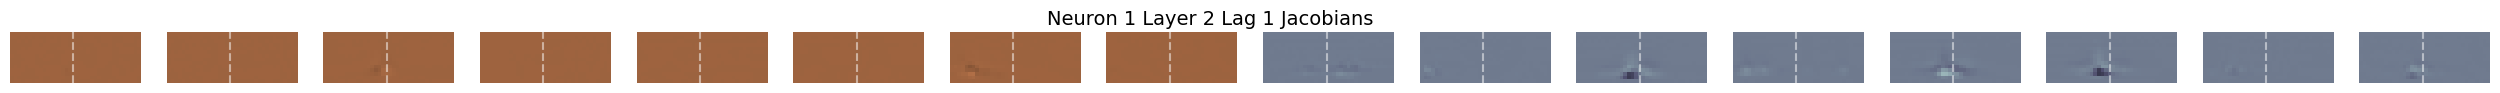

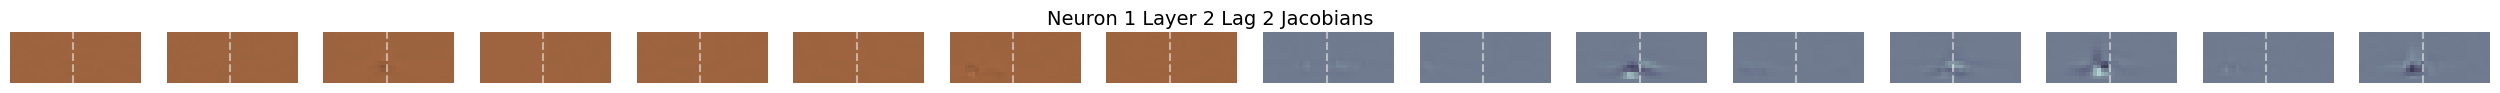

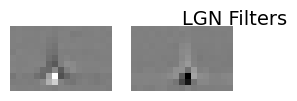

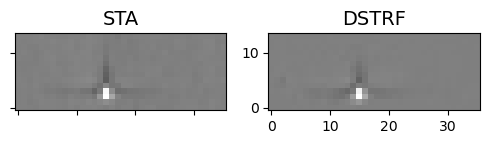

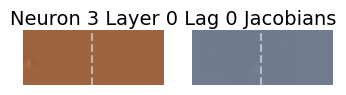

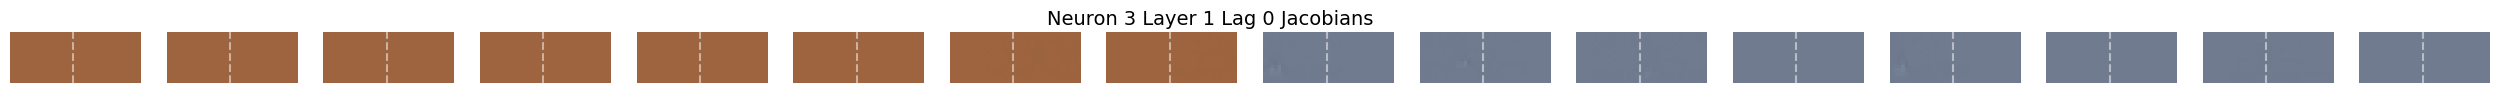

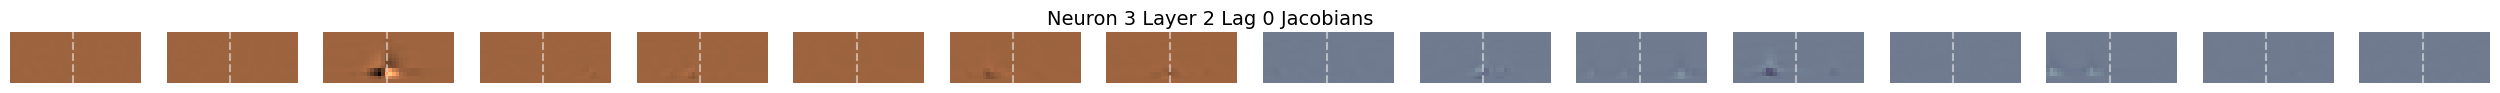

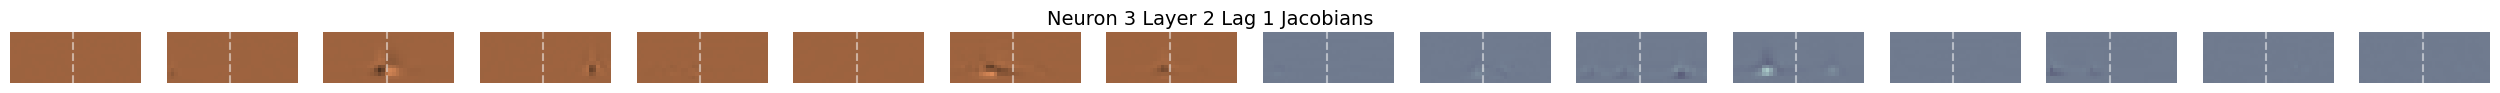

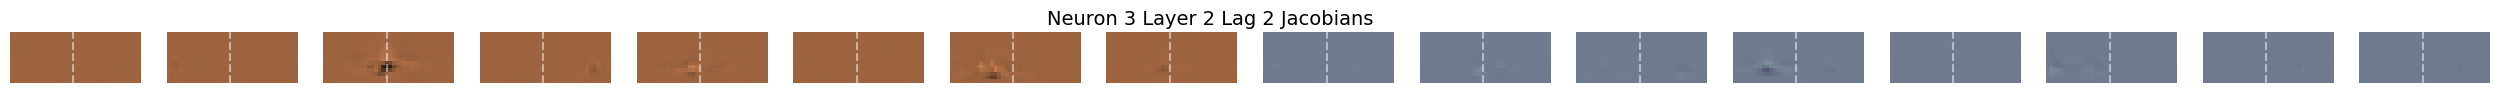

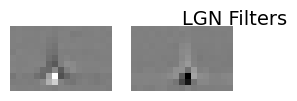

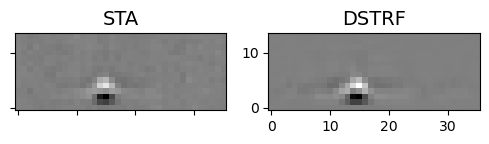

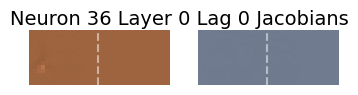

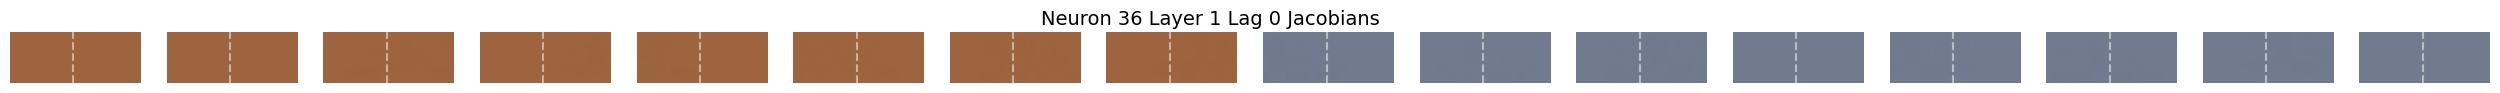

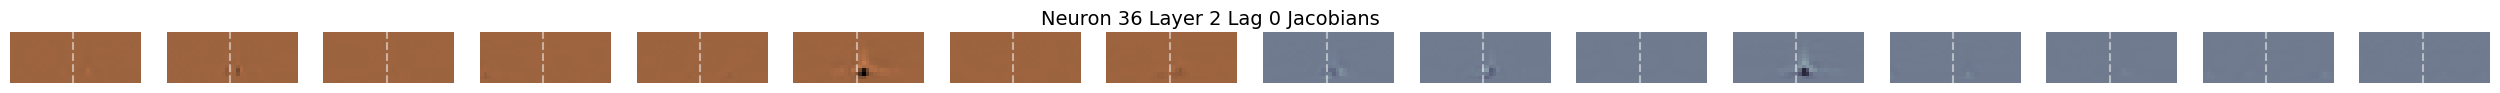

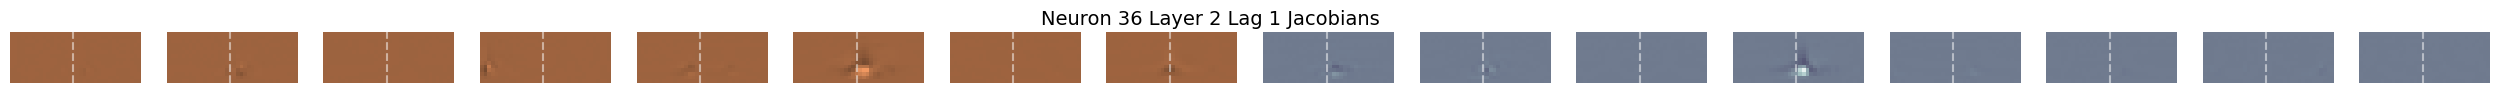

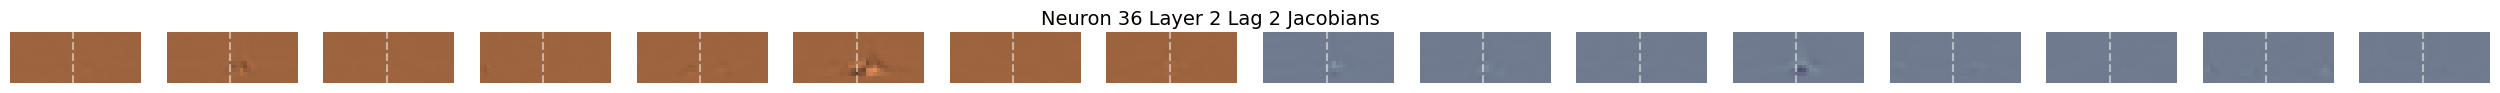

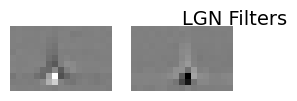

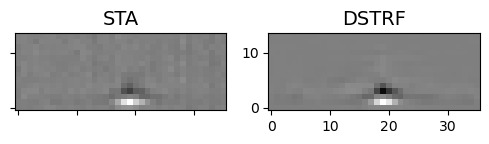

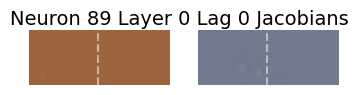

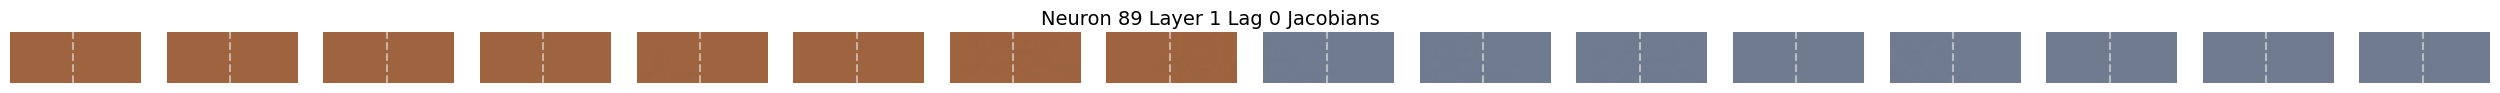

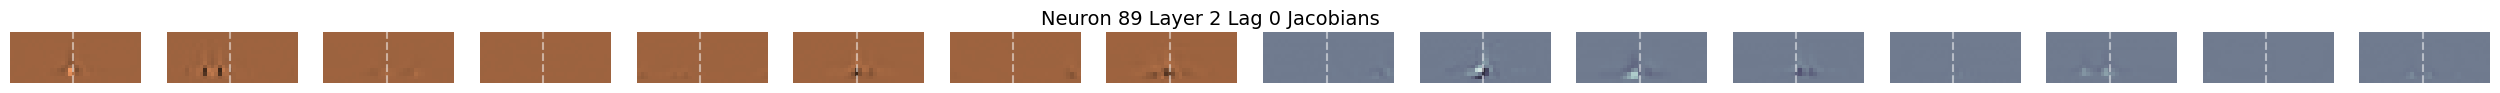

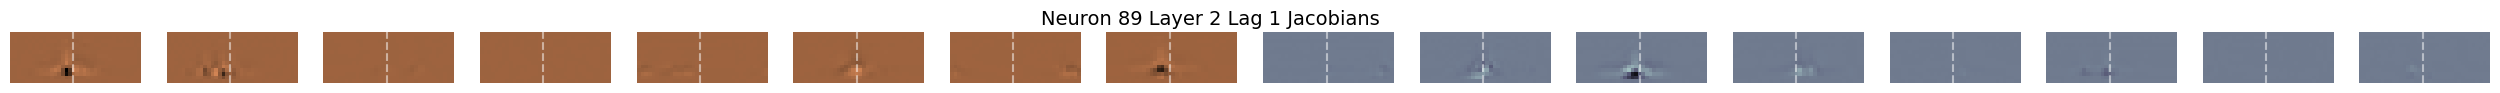

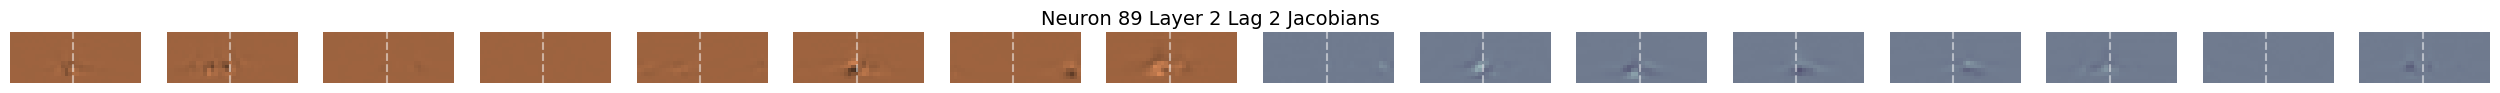

In [221]:
model = e.trials[0].model
neuron_readout_weights = model.networks[-1].layers[-1].weights[:,:,dirsel_neurons]
# normalize the weights
neuron_readout_weights = neuron_readout_weights / np.max(np.abs(neuron_readout_weights))

weighted_jacobians = []
weighted_jacobian_maxes = []
for neuron_idx in range(len(dirsel_neurons)):
    weighted_jacobians_neuron = []
    weighted_jacobian_max_neuron = 0
    neuron = dirsel_neurons[neuron_idx]
    jacobians = results[neuron_idx].jacobians
    
    neuron_readout_weights = model.networks[-1].layers[-1].weights[:,:,neuron_idx]
    
    start_weight_pos = 0
    print('Neuron readout weights shape', neuron_readout_weights.shape)
    for ni in [0]:
        print('Num layers', len(jacobians[ni]))
        for li in range(len(jacobians[ni])): # skip LGN for this one
            timepoints, lags, subunits, space, image = jacobians[ni][li].shape
            layer_readout_weights = neuron_readout_weights[start_weight_pos:start_weight_pos+subunits,:]
            print('-->', start_weight_pos, start_weight_pos+subunits)
            start_weight_pos += subunits
            print('Network', ni, 'Layer', li, 'Jacobian shape', jacobians[ni][li].shape, 'Neuron weights shape', neuron_readout_weights.shape)
            # for the last layer, use the number of lags,
            # otherwise, just use the first lag
            if li == len(jacobians[ni])-1:
                lags = lags
            else:
                lags = 1
            
            for lag in range(lags):
                layer_jacobians = np.mean(jacobians[ni][li], axis=0) # get the jacobian for this neuron
                print('Layer readout weights shape', layer_readout_weights.shape)
                print('Layer Jacobians shape', layer_jacobians.shape)
                for subunit in range(subunits):
                    # get a weighted sum of the l0_l1_reshaped and the neuron_readout_weights at this neuron
                    # # skip the first 4 going to the LGN
                    weighted_jacobian = layer_readout_weights[subunit,:].T @ layer_jacobians[lag,subunit,:,:]
                    weighted_jacobian_max_neuron = max(np.max(np.abs(weighted_jacobian)), weighted_jacobian_max_neuron)
                    weighted_jacobians_neuron.append(weighted_jacobian)
    weighted_jacobians.append(weighted_jacobians_neuron)
    weighted_jacobian_maxes.append(weighted_jacobian_max_neuron)
                    
print(len(weighted_jacobians[0]))

# plot the Jacobians with proper min and max
for neuron_idx in range(len(dirsel_neurons)):
    i = 0
    neuron = dirsel_neurons[neuron_idx]
    jacobians = results[neuron_idx].jacobians
    filter_max = np.max(e.trials[0].model.networks[0].layers[0].weights)
    filter_min = -filter_max
    fig = plt.figure(figsize=(6,1))
    for k in range(2):
        plt.subplot(1,4,k+1)
        # plot the weights for the first layer
        plt.imshow(model.networks[0].layers[0].weights[:,:,k].T, cmap='gray', origin='lower', vmin=filter_min, vmax=filter_max)
        plt.axis('off')
    plt.suptitle('LGN Filters', fontsize=14)

    # Calculate STA
    num_lags = 14
    Reff = dataset.robs * dataset.dfs
    nspks = torch.sum(Reff, axis=0)
    stas = (dataset.stim.T@dataset.robs / nspks).reshape([-1, num_lags, dataset.NC]).detach().numpy()
    # plot DSTRF for the neuron 1
    fig = plt.figure(figsize=(6,1))
    plt.subplot(1,2,1)
    plot.imagesc(stas[:, :, neuron], aspect='auto', cmap='gray_r', colrow=True, axis_labels=False)
    plt.title('STA', fontsize=14)
    plt.subplot(1,2,2)
    plot.imagesc(np.mean(jacobians[-1][-1][:,neuron,:], axis=0).reshape(36,14), cmap='gray_r', origin='lower')
    plt.title('DSTRF', fontsize=14)
    for ni in [0]:
        for li in range(len(jacobians[ni])): # skip LGN for this one
            timepoints, lags, subunits, space, image = jacobians[ni][li].shape
            if li == len(jacobians[ni])-1:
                lags = lags
            else:
                lags = 1
            for lag in range(lags):
                fig = plt.figure(figsize=(subunits*2,1))
                for subunit in range(subunits):
                    plt.subplot(1,subunits,subunit+1)
                    if subunit >= subunits//2: # inhibitory subunits
                        cmap = 'bone'
                    else:
                        cmap = 'copper'
                    plt.imshow(weighted_jacobians[neuron_idx][i].reshape(36,14).T, cmap=cmap, origin='lower', 
                               vmin=-weighted_jacobian_maxes[neuron_idx], vmax=weighted_jacobian_maxes[neuron_idx])
                    plt.axis('off')
                    # draw a vertical line at the center of the receptive field
                    plt.axvline(x=17, color='white', linestyle='--', alpha=0.5)
                    i += 1
                plt.suptitle('Neuron ' + str(neuron) + ' Layer ' + str(li) + ' Lag ' + str(lag) + ' Jacobians', fontsize=14)

# readout quantifications

In [212]:
# TODO: compare lag-wise activations across the layers for the direction selective neurons to the non-direction selective neurons

Readout weights shape (66, 36, 111)


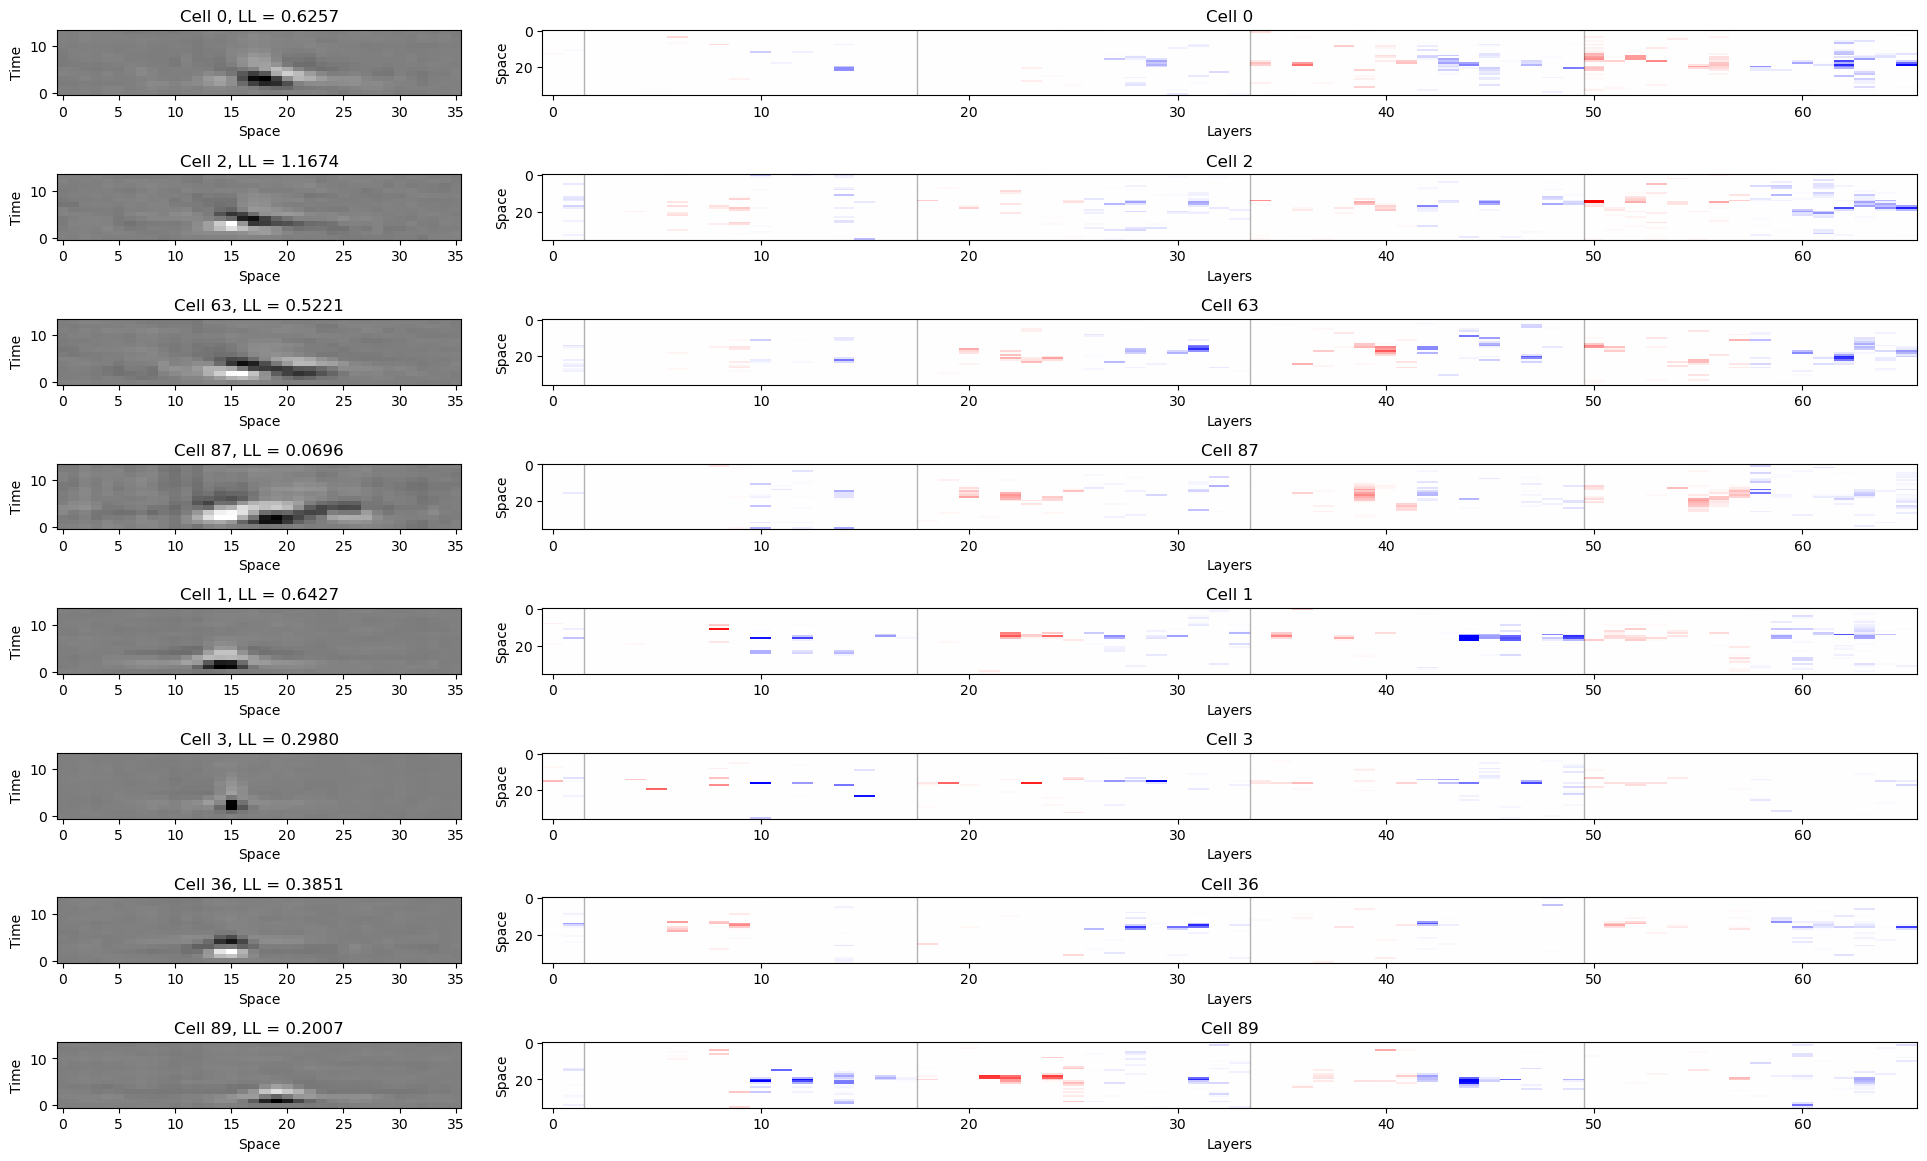

In [222]:
# get the weights
readout_weights = e.trials[0].model.networks[1].layers[0].weights
print('Readout weights shape', readout_weights.shape)
readout_weights[1,:,:] = -readout_weights[1,:,:]
for i in range(10,readout_weights.shape[0],16):
    readout_weights[i:i+8,:,:] = -readout_weights[i:i+8,:,:]

pred_max = np.max(pred[:,:,dirsel_neurons])
pred_min = -pred_max

readout_max = np.max(readout_weights[:,:,dirsel_neurons])
readout_min = -readout_max

fig = plt.figure(figsize=(24,14))
rows,cols = len(dirsel_neurons),4
gridspec = fig.add_gridspec(rows,cols)
# put vertical space between the plots
gridspec.update(wspace=0.2, hspace=1.2)

cc = 0
for cc in range(len(dirsel_neurons)):
    ax = fig.add_subplot(gridspec[cc,0])
    plot.imagesc(pred[:,:,dirsel_neurons[cc]], cmap='gray', ax=ax)
    ax.set_title('Cell '+str(dirsel_neurons[cc])+', LL = %.4f' % e.trials[0].LLs[dirsel_neurons[cc]])
    ax.set_xlabel('Space')
    ax.set_ylabel('Time')

    ax = fig.add_subplot(gridspec[cc,1:])
    ax.imshow(readout_weights[:,:,dirsel_neurons[cc]].T, cmap='bwr', aspect='auto', vmin=readout_min, vmax=readout_max, interpolation='none')
    ax.set_xlabel('Layers')
    ax.set_ylabel('Space')
    ax.set_title('Cell '+str(dirsel_neurons[cc]))

    # draw a vertical line between each layer
    for layer_boundary in layer_boundaries[1:-1]:
        # shift the line back by 0.5
        ax.axvline(layer_boundary-0.5, color='k', linewidth=1, alpha=0.3)

    cc += 1

In [215]:
# quantify the relative amount of excitatory and inhibitory weights across the layers for each neuron
readout_weights.shape, np.sum(readout_weights[10:18,:,dirsel_neurons[:4]], axis=(0,1))

((66, 36, 111),
 array([-1.2622925, -1.46168  , -1.1463182, -1.999385 ], dtype=float32))

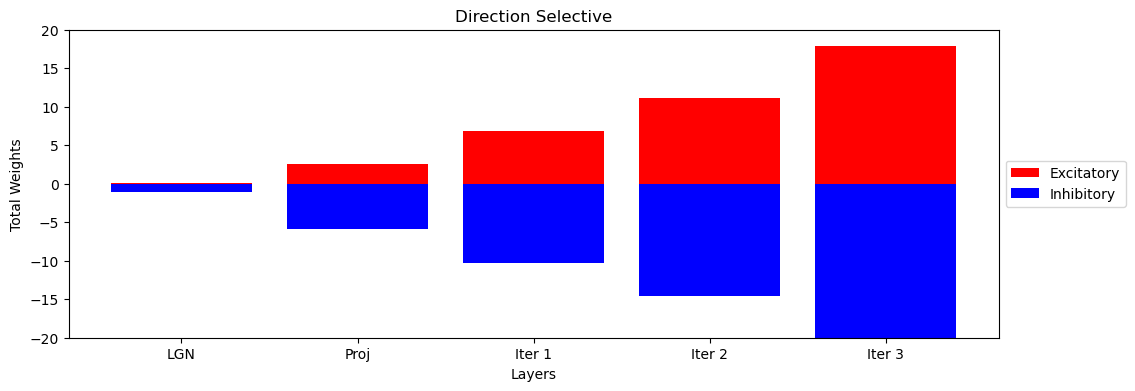

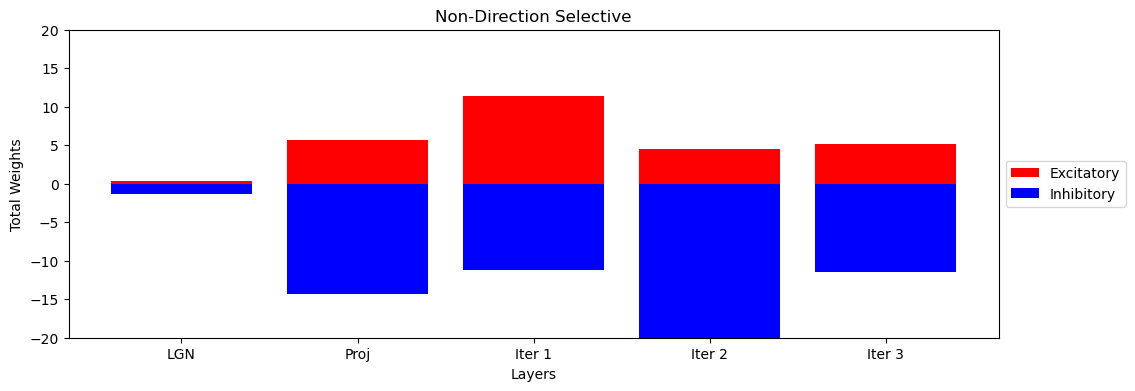

In [223]:
# sum up every 8 units to get the total exc and inh weights
dir_exc = [np.sum(readout_weights[0,:,dirsel_neurons[:4]])]
dir_inh = [np.sum(readout_weights[1,:,dirsel_neurons[:4]])]
non_exc = [np.sum(readout_weights[0,:,dirsel_neurons[4:]])]
non_inh = [np.sum(readout_weights[1,:,dirsel_neurons[4:]])]
for i in range(2,readout_weights.shape[0],16):
    dir_exc.append(np.sum(readout_weights[i:i+8,:,dirsel_neurons[:4]]))
    dir_inh.append(np.sum(readout_weights[i+8:i+16,:,dirsel_neurons[:4]]))
    non_exc.append(np.sum(readout_weights[i:i+8,:,dirsel_neurons[4:]]))
    non_inh.append(np.sum(readout_weights[i+8:i+16,:,dirsel_neurons[4:]]))

# plot the bar plots for the direction selective and non-direction selective neurons across layers
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.bar(np.arange(1,6), dir_exc, color='r', label='Excitatory')
ax.bar(np.arange(1,6), dir_inh, color='b', label='Inhibitory')
ax.set_xticks(np.arange(1,6))
ax.set_xticklabels(['LGN', 'Proj', 'Iter 1', 'Iter 2', 'Iter 3'])
ax.set_ylim([-20, 20])
ax.set_ylabel('Total Weights')
ax.set_xlabel('Layers')
ax.set_title('Direction Selective')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.bar(np.arange(1,6), non_exc, color='r', label='Excitatory')
ax.bar(np.arange(1,6), non_inh, color='b', label='Inhibitory')
ax.set_xticks(np.arange(1,6))
ax.set_xticklabels(['LGN', 'Proj', 'Iter 1', 'Iter 2', 'Iter 3'])
ax.set_ylim([-20, 20])
ax.set_ylabel('Total Weights')
ax.set_xlabel('Layers')
ax.set_title('Non-Direction Selective')
# put the legend on the left side
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Direction selective excitatory weights (4,)


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (5,) and arg 1 with shape (5, 4).

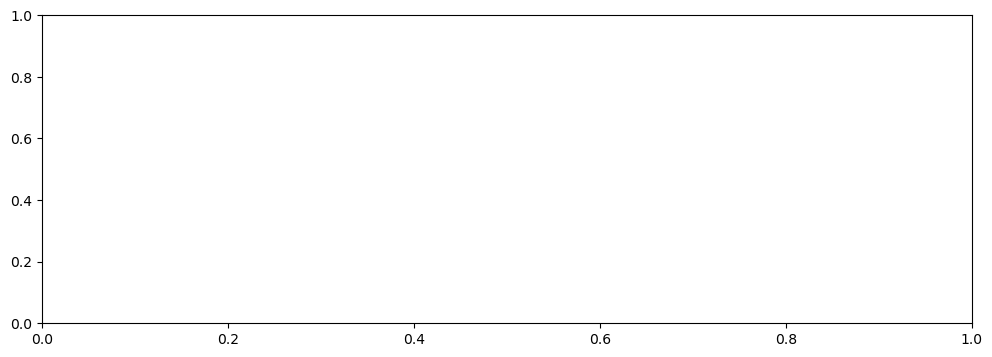

In [220]:
# sum up every 8 units to get the total exc and inh weights
dir_exc = [np.sum(readout_weights[0,:,dirsel_neurons[:4]], axis=1)]
dir_inh = [np.sum(readout_weights[1,:,dirsel_neurons[:4]], axis=1)]
non_exc = [np.sum(readout_weights[0,:,dirsel_neurons[4:]], axis=1)]
non_inh = [np.sum(readout_weights[1,:,dirsel_neurons[4:]], axis=1)]
for i in range(2,readout_weights.shape[0],16):
    dir_exc.append(np.sum(readout_weights[i:i+8,:,dirsel_neurons[:4]], axis=(0,1)))
    dir_inh.append(np.sum(readout_weights[i+8:i+16,:,dirsel_neurons[:4]], axis=(0,1)))
    non_exc.append(np.sum(readout_weights[i:i+8,:,dirsel_neurons[4:]], axis=(0,1)))
    non_inh.append(np.sum(readout_weights[i+8:i+16,:,dirsel_neurons[4:]], axis=(0,1)))

print('Direction selective excitatory weights', dir_exc[2].shape)

# plot a histogram of the total weights for each neuron across the layers




# plot the bar plots for the direction selective and non-direction selective neurons across layers
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.bar(np.arange(1,6), dir_exc, color='r', label='Excitatory')
ax.bar(np.arange(1,6), dir_inh, color='b', label='Inhibitory')
ax.set_xticks(np.arange(1,6))
ax.set_xticklabels(['LGN', 'Proj', 'Iter 1', 'Iter 2', 'Iter 3'])
ax.set_ylim([-20, 20])
ax.set_ylabel('Total Weights')
ax.set_xlabel('Layers')
ax.set_title('Direction Selective')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.bar(np.arange(1,6), non_exc, color='r', label='Excitatory')
ax.bar(np.arange(1,6), non_inh, color='b', label='Inhibitory')
ax.set_xticks(np.arange(1,6))
ax.set_xticklabels(['LGN', 'Proj', 'Iter 1', 'Iter 2', 'Iter 3'])
ax.set_ylim([-20, 20])
ax.set_ylabel('Total Weights')
ax.set_xlabel('Layers')
ax.set_title('Non-Direction Selective')
# put the legend on the left side
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
# quantify the spatial extent of the weights (second dimension of the readout_weights) similar to the above

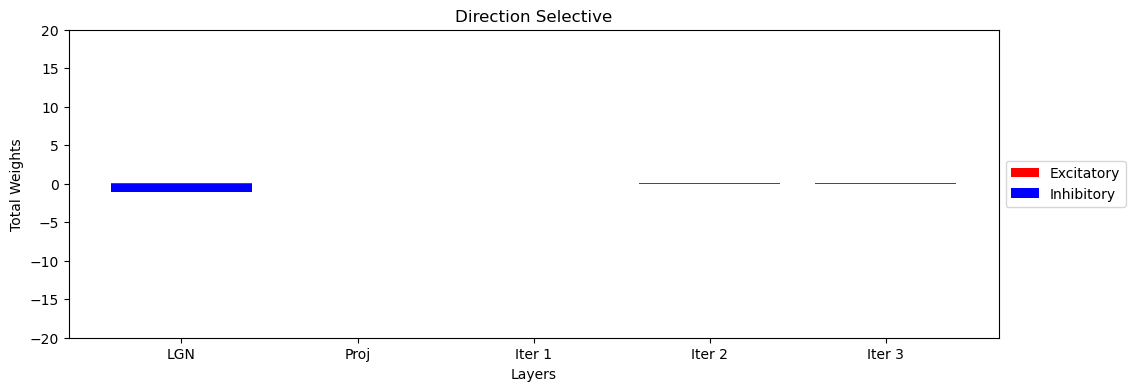

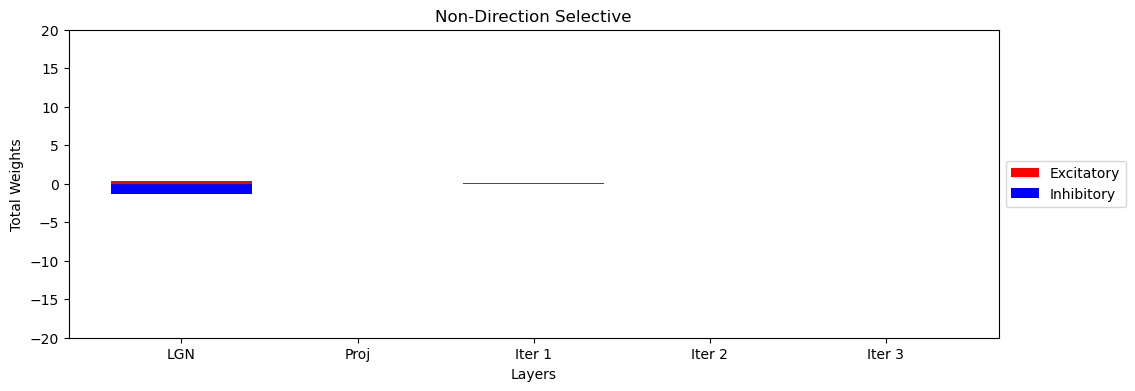

In [208]:
# sum up every 8 units to get the total exc and inh weights
dir_exc = [np.sum(readout_weights[0,:,dirsel_neurons[:4]])]
dir_inh = [np.sum(readout_weights[1,:,dirsel_neurons[:4]])]
non_exc = [np.sum(readout_weights[0,:,dirsel_neurons[4:]])]
non_inh = [np.sum(readout_weights[1,:,dirsel_neurons[4:]])]
for i in range(2,readout_weights.shape[0],16):
    dir_exc.append(np.mean(np.sum(readout_weights[i:i+8,:,dirsel_neurons[:4]], axis=2)))
    dir_inh.append(np.mean(np.sum(readout_weights[i+8:i+16,:,dirsel_neurons[:4]], axis=2)))
    non_exc.append(np.mean(np.sum(readout_weights[i:i+8,:,dirsel_neurons[4:]], axis=2)))
    non_inh.append(np.mean(np.sum(readout_weights[i+8:i+16,:,dirsel_neurons[4:]], axis=2)))
    
# plot the bar plots for the direction selective and non-direction selective neurons across layers
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.bar(np.arange(1,6), dir_exc, color='r', label='Excitatory')
ax.bar(np.arange(1,6), dir_inh, color='b', label='Inhibitory')
ax.set_xticks(np.arange(1,6))
ax.set_xticklabels(['LGN', 'Proj', 'Iter 1', 'Iter 2', 'Iter 3'])
ax.set_ylim([-20, 20])
ax.set_ylabel('Total Weights')
ax.set_xlabel('Layers')
ax.set_title('Direction Selective')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.bar(np.arange(1,6), non_exc, color='r', label='Excitatory')
ax.bar(np.arange(1,6), non_inh, color='b', label='Inhibitory')
ax.set_xticks(np.arange(1,6))
ax.set_xticklabels(['LGN', 'Proj', 'Iter 1', 'Iter 2', 'Iter 3'])
ax.set_ylim([-20, 20])
ax.set_ylabel('Total Weights')
ax.set_xlabel('Layers')
ax.set_title('Non-Direction Selective')
# put the legend on the left side
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# subunit jacobians

In [49]:
# look at DSTRFs in the subunits when they are activated

# is the DSTRF higher when the subunit is activated?
# get the outputs for the experiment

results_outputs = predict.predict_batch(e.trials[0].model, dataset, calc_jacobian=True, verbose=False, batch_size=5, end=15)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.44it/s]
/home/mattjac/projects/mattjac/v1/./lib/predict.py:148: RuntimeWarning: divide by zero encountered in divide
  r2 = 1 - np.sum((robs - pred)**2, axis=0) / np.sum((robs - np.mean(robs))**2, axis=0)

100%|██████████████████████████████████████████████████████████████████████

In [57]:
results_outputs.outputs[1][0].shape

(15, 111)

In [250]:
# num_lags x num_filters
for ni in range(len(results_outputs.outputs)):
    for li in range(len(results_outputs.outputs[ni])):
        #num_filters = model.networks[ni].layers[li].params['num_filters']
        #print(results_outputs.outputs[ni][li].shape, results_outputs.outputs[ni][li].shape[1]/num_filters/36)
        print(results_outputs.outputs[ni][li].shape)

(10, 4, 2, 36)
(10, 4, 16, 36)
(10, 3, 16, 36)
(10, 111)
